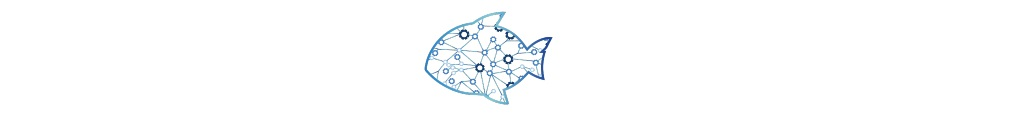

# DETECCIÓN DE ANOMALÍAS CON LSTM


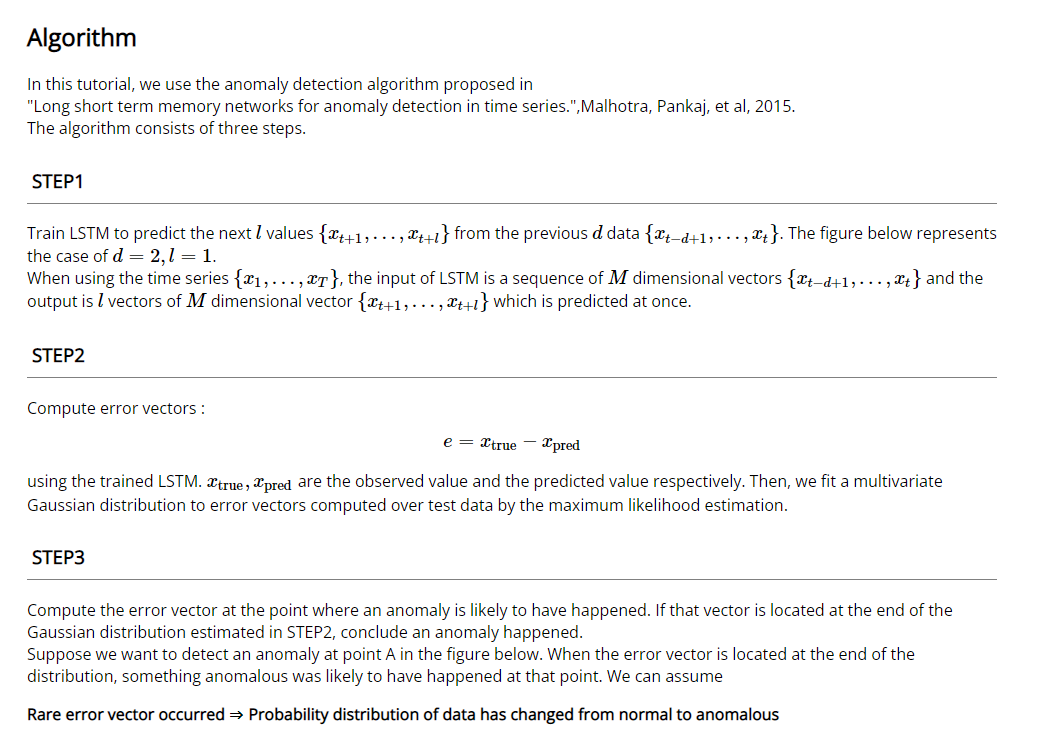

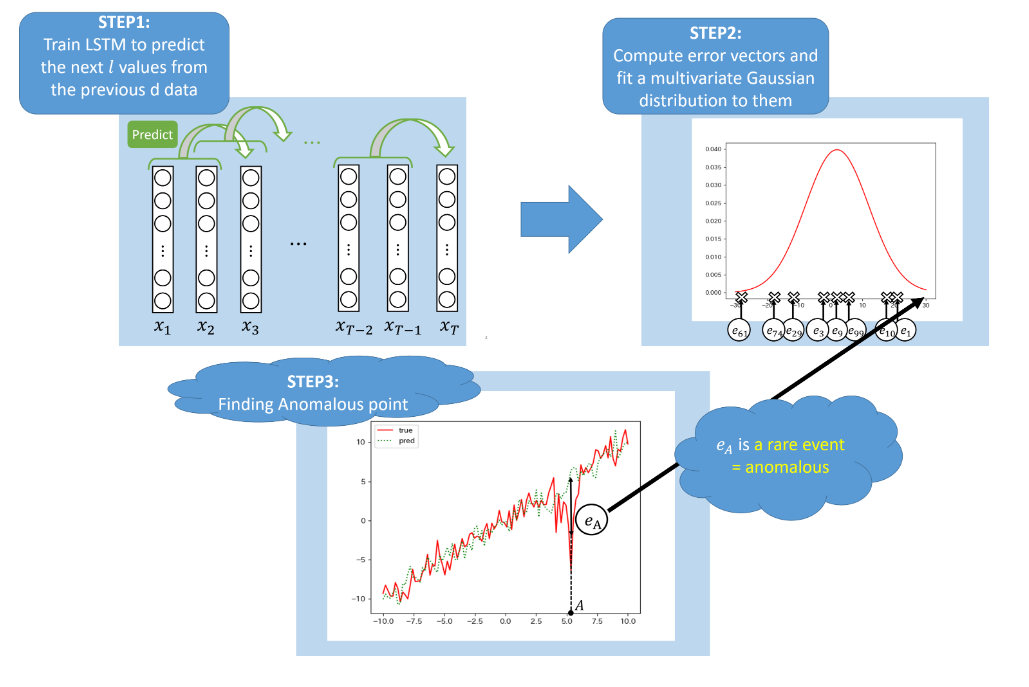

## LIBRERÍAS

* ReNom 2.6.2
* matplotlib 2.2.2
* pandas 0.23.1
* numpy 1.14.5
* scikit-learn 0.19.1
* scipy 1.1.0

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler


#import renom as rm
#from renom.optimizer import Adam
#from renom.cuda import set_cuda_active
#set_cuda_active(False)

## Dataset
We will use the ECG dataset, qtdb/sel102 ECG dataset [2].

It can be downloaded from

http://www.cs.ucr.edu/~eamonn/discords/



# PASO 1

## Preprocessing

Firstly, we will standardize the ECG data and plot a part of it (time = 0-5000) to see the structure.



In [21]:
df = pd.read_csv('/content/qtdbsel102.txt', header=None, delimiter='\t')


# una sola columna, pero para operar necesito convertirla en arra
ecg = df.iloc[:,2].values   #selecciono la última columna y la convierto en array horizontal
ecg = ecg.reshape(len(ecg), -1)  #la convierto en array vertical (columna) y tiene 45000 valores y 1 sola columna
print(ecg.shape)
print('length of ECG data : ', len(ecg))


(45000, 1)
length of ECG data :  45000


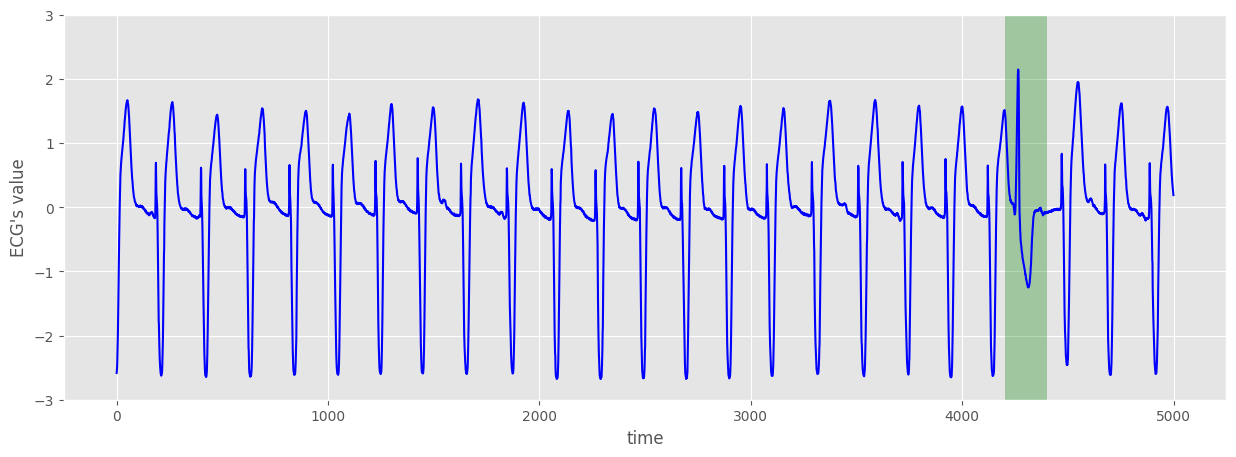

In [4]:
# standardize
scaler = StandardScaler()
std_ecg = scaler.fit_transform(ecg)

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000), std_ecg[:5000], color='b')
plt.ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
plt.fill_between(x, y1, y2, facecolor='g', alpha=.3)
plt.show()

Como se muestra en el gráfico anterior, estos datos son periódicos. También podemos observar que hay un punto de cambio alrededor del tiempo 4250 porque la periodicidad está colapsando alrededor de ahí. Dado que el objetivo del PASO 1 es aprender LSTM a partir de datos normales, utilizaremos los datos posteriores al tiempo 5000 como datos de entrenamiento.

### Buscamos una zona normal, sin anomalías y esa es la que utilizamos para entrenar el modelo

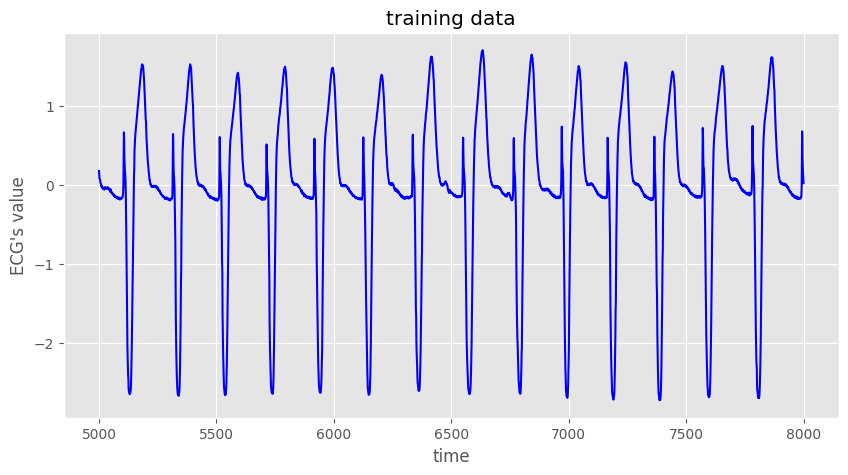

In [5]:
# Buscamos una zona normal, donde no haya anomalías para poder comparar 

normal_cycle = std_ecg[5000:]

plt.figure(figsize=(10,5))
plt.title("training data")
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000,8000), normal_cycle[:3000], color='b')# stop plot at 8000 times for friendly visual
plt.show()

Se ve que por encima de la anomalía, que estaba en time=4200, el comportamiento es normal.



Aclaración: normalmente se usa esto

* LOOKBACK 
El “lookback period” define cuántos intervalos de tiempo anteriores se utilizan para predecir el intervalo de tiempo posterior. En este sentido, estamos utilizando un modelo de predicción de un paso.  Si ponemos un look back =5, estaremos usando los time steps: t-4, t-3, t-2, t-1, y t para predecir t+1.

* SUBSEQUENCE
Subsequence time series clustering is used for discovering structures or patterns in time series data. Subsequence time series clustering leads to many interesting data, including sequential patterns, motifs, periodic patterns, partially ordered patterns, and approximate biological sequence patterns.




METER ESTO EN TF
https://downloads.hindawi.com/journals/tswj/2014/312521.pdf 

* Definition 1. A time series 𝑇 of size 𝑚 is an ordered sequence
of real-value data, where 𝑇 = (𝑡1, 𝑡2 ...𝑡𝑚). Figure 1
shows a sample of time series data.

* Definition 2. A subsequence of length d of time series 𝑇 is
𝑇𝑖,d = (𝑡𝑖, 𝑡𝑖+1,...,𝑡𝑖+d−1), where 1 ≤ 𝑖 ≤ 𝑚−d+1 [33].
A subsequence is an arranged sequence of data that omits
some elements without changing the order of the remaining
elements (ver imagen).

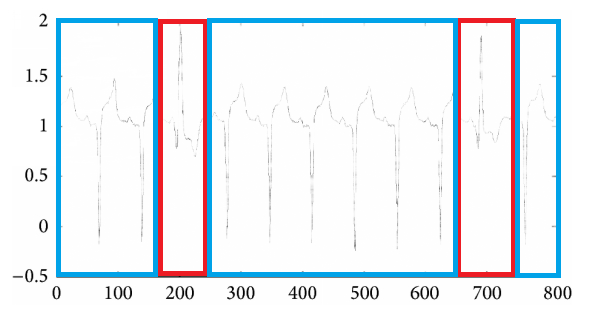

Las zonas rojas se eliminan y las zonas azules son con las que entrenamos

En nuestro problema, se supone que solo tenemos una zona con anomalías así que hemos eliminado todo por debajo de time=5000. Ahora definiremos la función que crea conjuntos de una subsecuencia de d longitud y una etiqueta de l dimensión de la siguiente manera:
* cogemos un período de tiempo de comportamiento normal: ts (>5000)
* fijamos un lookback, aquí la ventana coge 10
* fijamos unos forward steps: pred_leng  (vamos a obtener los 3 próximos valores)



nota: las LSTM PUEDEN SACAR UN VECTOR DE SALIDA CON UNA PREDICCIÓN MULTISTEP. SE HACE ASÍ

model.add(Dense(n_steps_out))
  

)
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [6]:
# create data of the "look_back" length from time-series, "ts"
# and the next "pred_length" values as labels
def create_subseq(ts, look_back, pred_length):
    sub_seq, next_values = [], []
    for i in range(len(ts)-look_back-pred_length):  
        sub_seq.append(ts[i:i+look_back])
        next_values.append(ts[i+look_back:i+look_back+pred_length].T[0])
    return sub_seq, next_values

In this tutorial, we will set d=10,l=3


In [7]:
look_back = 10        #### IMPORTANTE
pred_length = 3
# el período sin anomalias es normal_cycle

sub_seq, next_values = create_subseq(normal_cycle, look_back, pred_length)


X_train, X_test, y_train, y_test = train_test_split(
    sub_seq, next_values, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


train_size = X_train.shape[0]
test_size = X_test.shape[0]
print('train size:{}, test size:{}'.format(train_size, test_size))

train size:31989, test size:7998


Inicialmente teníamos 45000 valores, hemos quitado la zona de la anomalía para entrenar el modelo. El nuevo dataset tiene 39987 valores (train 31989 y test 7998).
Comprobamos:

In [33]:
# Veremos que la entrada del conjunto de entrenamiento está formada por 31989 valores de 10 lookback
X_train.shape

(31989, 10, 1)

In [35]:
X_train[12]

array([[1.16524934],
       [1.09702637],
       [1.01174765],
       [0.91367712],
       [0.83266234],
       [0.77296724],
       [0.6962164 ],
       [0.61520161],
       [0.55124258],
       [0.51286715]])

In [38]:
# Ahora vemos que la salida del conjunto de entrenamient está formada por 31989 valores de 3 valores hacia adelante
y_train.shape

(31989, 3)

In [37]:
y_train[12]

array([0.44464418, 0.42758844, 0.32951791])

## Model Definition


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(3))    # HEMOS PUESTO UN MULTISTEP DE 3 PORQUE ANTES DEFINIMOS EL OUTPUT COMO 3 STEPS
model.compile(loss='mae', optimizer='adam')



## Entrenar red

Epoch 1/10
15995/15995 - 66s - loss: 0.0532 - val_loss: 0.0453 - 66s/epoch - 4ms/step
Epoch 2/10
15995/15995 - 62s - loss: 0.0329 - val_loss: 0.0273 - 62s/epoch - 4ms/step
Epoch 3/10
15995/15995 - 65s - loss: 0.0276 - val_loss: 0.0304 - 65s/epoch - 4ms/step
Epoch 4/10
15995/15995 - 65s - loss: 0.0257 - val_loss: 0.0271 - 65s/epoch - 4ms/step
Epoch 5/10
15995/15995 - 62s - loss: 0.0248 - val_loss: 0.0273 - 62s/epoch - 4ms/step
Epoch 6/10
15995/15995 - 62s - loss: 0.0243 - val_loss: 0.0273 - 62s/epoch - 4ms/step
Epoch 7/10
15995/15995 - 62s - loss: 0.0238 - val_loss: 0.0256 - 62s/epoch - 4ms/step
Epoch 8/10
15995/15995 - 66s - loss: 0.0235 - val_loss: 0.0247 - 66s/epoch - 4ms/step
Epoch 9/10
15995/15995 - 65s - loss: 0.0232 - val_loss: 0.0243 - 65s/epoch - 4ms/step
Epoch 10/10
15995/15995 - 62s - loss: 0.0229 - val_loss: 0.0225 - 62s/epoch - 4ms/step


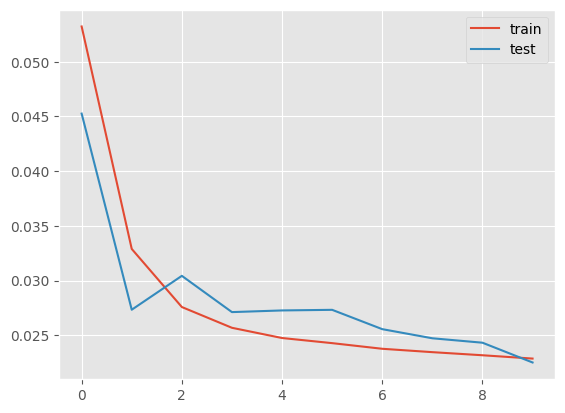

In [40]:
# fit network
history = model.fit(X_train, y_train, epochs=10, batch_size=2, validation_data=(X_test, y_test), verbose=2, shuffle=False)    #500 8
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# PASO 2

## Fitting an M  dimensional Gaussian distribution

 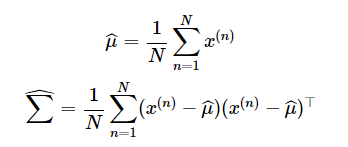

In [47]:
# make a prediction
pred = model.predict(X_test)

# computing errors
errors = y_test - pred

# Media de los errores
mean = sum(errors)/len(errors)

# Covarianza de los errores
cov = 0
for e in errors:
    cov += np.dot((e-mean).reshape(len(e), 1), (e-mean).reshape(1, len(e)))
cov /= len(errors)

print('mean : ', mean)
print('cov : ', cov)

250/250 [==============================] - 1s 2ms/step
mean :  [0.00325509 0.00955863 0.01129576]
cov :  [[0.00113795 0.00161957 0.0015171 ]
 [0.00161957 0.00406127 0.0042324 ]
 [0.0015171  0.0042324  0.00624619]]


In [42]:
# COMPROBAMOS QUE EL MULTISTEP=3, como tenemos en y_train e y_test
pred.shape

(7998, 3)

# PASO 3

## Anomaly Detection (STEP3)

Verificaremos si este algoritmo funciona incluso para datos desconocidos.
En primer lugar, crearemos conjuntos de una subsecuencia y una etiqueta. Luego calcularemos los vectores de error de la misma manera.

In [80]:
# calculate Mahalanobis distance
def Mahala_distantce(x,mean,cov):
    d = np.dot(x-mean,np.linalg.inv(cov))
    d = np.dot(d, (x-mean).T)
    return d

# Ahora vamos a buscar la zona donde estaba la anomalía, por debajo de 5000
sub_seq, next_values = create_subseq(std_ecg[:5000], look_back, pred_length)
sub_seq = np.array(sub_seq)
next_values = np.array(next_values)

pred = model(sub_seq[:,t])



In [81]:
pred.shape

TensorShape([4987, 3])

In [82]:
type(next_values)

numpy.ndarray

In [83]:
# para que sean iguales y poder operar, convierto el tensor pred en un array de numpy
pred=pred.numpy()
type(pred)

numpy.ndarray

In [84]:
errors = next_values - pred

En segundo lugar, trazaremos la distancia de Mahalanobis para cada vector de error y los datos de ECG correspondientes.

In [85]:
m_dist = [0]*look_back 
for e in errors:
    m_dist.append(Mahala_distantce(e,mean,cov))



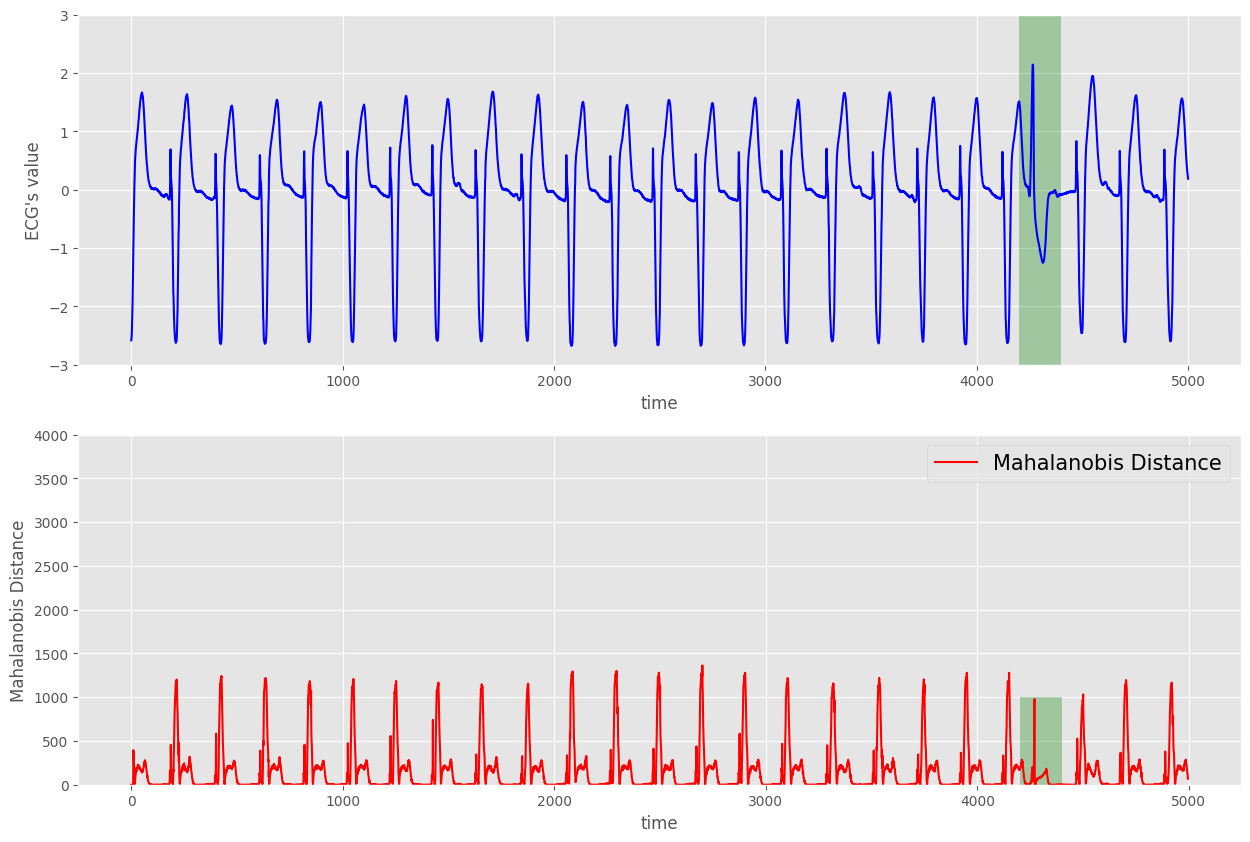

In [87]:
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(std_ecg[:5000],color='b',label='original data')
axes[0].set_xlabel('time')
axes[0].set_ylabel('ECG\'s value' )
axes[0].set_ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
axes[0].fill_between(x, y1, y2, facecolor='g', alpha=.3)

axes[1].plot(m_dist, color='r',label='Mahalanobis Distance')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_ylim(0, 4000)
y1 = [0]*len(x)
y2 = [1000]*len(x)
axes[1].fill_between(x, y1, y2, facecolor='g', alpha=.3)

plt.legend(fontsize=15)
plt.show()

Como podemos ver en la figura anterior, la distancia de Mahalanobis (una medida de rareza) aumentó alrededor del tiempo 4250 en comparación con otras partes. Como vimos en la parte de preprocesamiento, estos datos tienen el punto de colapso de periodicidad alrededor del tiempo 4250. Como resultado, pudimos detectar la anomalía.



# Conclusión

Explicamos el algoritmo de detección de anomalías para datos de series temporales utilizando LSTM. Como se muestra en la parte del experimento, pudimos encontrar la anomalía por rareza, en otras palabras, la ubicación en la distribución.

# Referencias
[1] Malhotra, Pankaj, et al. "Long short term memory networks for anomaly detection in time series." Proceedings. Presses universitaires de Louvain, 2015.

[2] E. Keogh, J. Lin and A. Fu (2005). HOT SAX: Efficiently Finding the Most Unusual Time Series Subsequence. In The Fifth IEEE International Conference on Data Mining.

[3] 井手剛, 杉山将. 『機械学習プロフェッショナルシリーズ　異常検知と変化検知』, 講談社, 2015.

BORRAR, S PRUEBA

In [26]:
df = pd.read_csv('/content/qtdbsel102.txt', header=None, delimiter='\t')


# una sola columna
ecg = df.iloc[:,2].values
ecg

array([2.1  , 2.135, 2.19 , ..., 5.085, 5.085, 5.115])

In [29]:
ecg[12]

array([4.53])

In [27]:

ecg = ecg.reshape(len(ecg), -1)
print(ecg.shape)
print('length of ECG data : ', len(ecg))

(45000, 1)
length of ECG data :  45000


In [31]:
ecg

array([[2.1  ],
       [2.135],
       [2.19 ],
       ...,
       [5.085],
       [5.085],
       [5.115]])